<a href="https://colab.research.google.com/github/arshiyasaiyad/Calculator/blob/main/creditcard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Any nulls in the dataset True
-------
No. of unique labels 3
Label values [ 0.  1. nan]
-------
Break down of Normal and Fraud Transactions
0.0    13897
1.0       56
Name: Class, dtype: int64


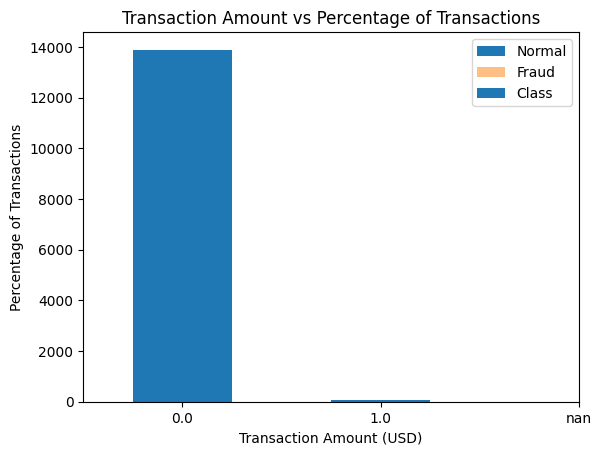

No. of records in Fraud Train Data = 48
No. of records in Normal Train Data = 11115
No. of records in Fraud Test Data = 9
No. of records in Normal Test Data = 2782
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 14)                434       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 4)                 32        
                                                                 
 dense_3 (Dense)             

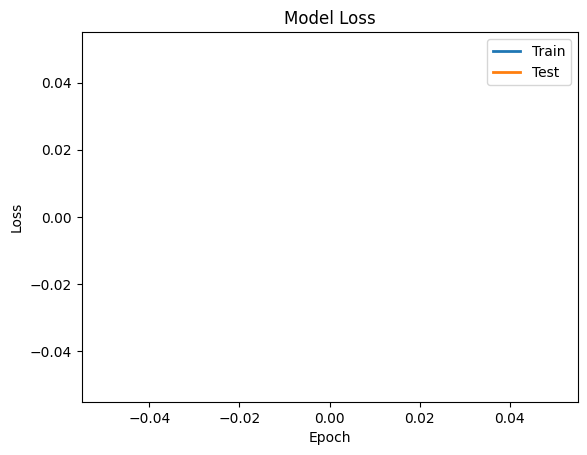

88/88 [==============================] - 0s 2ms/step


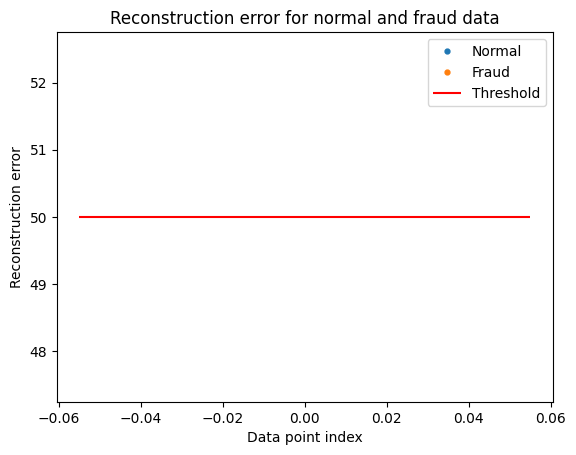

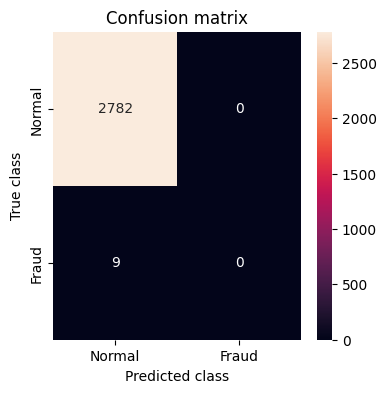

Accuracy: 0.9967753493371552
Recall: 0.0
Precision: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
# a. IMPORTING REQUIRED LIBRARIES ->
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

RANDOM_SEED = 2021
TEST_PCT = 0.3
LABELS = ["Normal", "Fraud"]

# b. UPLOAD / ACCESS THE DATASET ->
dataset = pd.read_csv("/creditcard.csv")

# Check for any null values
print("Any nulls in the dataset", dataset.isnull().values.any())
print('-------')
print("No. of unique labels", len(dataset['Class'].unique()))
print("Label values", dataset.Class.unique())

# 0 is for normal credit card transaction
# 1 is for fraudulent credit card transaction
print('-------')
print("Break down of Normal and Fraud Transactions")
print(pd.value_counts(dataset['Class'], sort=True))

# Visualizing the imbalanced dataset
count_classes = pd.value_counts(dataset['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.xticks(range(len(dataset['Class'].unique())), dataset.Class.unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations")

# Save the normal and fraudulent transactions in separate dataframes
normal_dataset = dataset[dataset.Class == 0]
fraud_dataset = dataset[dataset.Class == 1]

# Visualize transaction amounts for normal and fraudulent transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_dataset.Amount, bins=bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_dataset.Amount, bins=bins, alpha=0.5, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Transaction Amount vs Percentage of Transactions")
plt.xlabel("Transaction Amount (USD)")
plt.ylabel("Percentage of Transactions")
plt.show()

sc = StandardScaler()
dataset['Time'] = sc.fit_transform(dataset['Time'].values.reshape(-1, 1))
dataset['Amount'] = sc.fit_transform(dataset['Amount'].values.reshape(-1, 1))

raw_data = dataset.values
# The last element contains if the transaction is normal (0) or fraud (1)
labels = raw_data[:, -1]

# The other data points are the electrocardiogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=2021)

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

# Creating normal and fraud datasets
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

fraud_train_data = train_data[train_labels]
fraud_test_data = test_data[test_labels]
print("No. of records in Fraud Train Data =", len(fraud_train_data))
print("No. of records in Normal Train Data =", len(normal_train_data))
print("No. of records in Fraud Test Data =", len(fraud_test_data))
print("No. of records in Normal Test Data =", len(normal_test_data))

nb_epoch = 50
batch_size = 64
input_dim = normal_train_data.shape[1]
# num of columns, 30
encoding_dim = 14
hidden_dim1 = int(encoding_dim / 2)
hidden_dim2 = 4
learning_rate = 1e-7

# input layer
input_layer = tf.keras.layers.Input(shape=(input_dim,))

# c. ENCODER CONVERTS IT INTO LATENT REPRESENTATION

# Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh", activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder = tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim2, activation=tf.nn.leaky_relu)(encoder)

# d. DECODER NETWORKS CONVERT IT BACK TO THE ORIGINAL INPUT ->
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim1, activation='relu')(encoder)
decoder = tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)

# Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5", mode='min', monitor='val_loss', verbose=2, save_best_only=True)
# Define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=11,
    mode='min',
    restore_best_weights=True
)

# e. COMPILE THE MODEL WITH OPTIMIZER, LOSS, AND EVALUATION METRICS ->
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')

history = autoencoder.fit(normal_train_data, normal_train_data, epochs=nb_epoch,
                          batch_size=batch_size, shuffle=True,
                          validation_data=(test_data, test_data),
                          verbose=1,
                          callbacks=[cp, early_stop]).history

plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': test_labels})

threshold_fixed = 50
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label="Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label="Threshold")
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

threshold_fixed = 52
pred_y = [1 if e > threshold_fixed else 0
          for e in
          error_df.Reconstruction_error.values]
error_df['pred'] = pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()

# Print Accuracy, Precision, and Recall
print("Accuracy:", accuracy_score(error_df['True_class'], error_df['pred']))
print("Recall:", recall_score(error_df['True_class'], error_df['pred']))
print("Precision:", precision_score(error_df['True_class'], error_df['pred']))